# Basic Example

Este notebook prepara datos desde los ZIPs (`reals.zip`, `fakes.zip`), carga modelos **benchmark** de torchvision (VGG, ResNet, ALEXNET) según tu config y entrena **3 épocas** por transformación.

**Requisitos previos**:
- Carpeta del notebook: `notebooks/`
- Zips en `../dataset/` (al nivel del repo): `reals.zip`, `fakes.zip`
- (Opcional) modelos de usuario TorchScript en `../models/`


In [3]:
# 1) Rutas y pathing del proyecto (este notebook vive en notebooks/)
import sys, os
from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path.insert(0, lib_path)
print("Project root added to sys.path:", lib_path)


Project root added to sys.path: D:\UMNG-2025\FakeVoice\FakeVoice


In [4]:
# 2) Imports principales
from pprint import pprint
from fakevoicefinder import ExperimentConfig, CreateExperiment, ModelLoader, Trainer, ConfigError


In [5]:
# 3) Configuración del experimento
cfg = ExperimentConfig()

# Nombre del experimento (carpeta bajo outputs/)
cfg.run_name = "exp_with_metrics"

# Ubicaciones (repo-relativas)
cfg.data_path = "../dataset"   # donde están reals.zip y fakes.zip
cfg.models_path = "../models"  # modelos de usuario TorchScript

# Transforms a generar
cfg.transform_list = ["mel","log"]

# Modelos benchmark a probar
cfg.models_list = ["alexnet","vgg16", "resnet18"]

# Entrenamiento rápido de smoke-test
cfg.type_train = "both"   # 'scratch' | 'pretrain' | 'both'
cfg.epochs = 3
cfg.batch_size = 8
cfg.learning_rate = 0.0001
cfg.patience = 5

# Canal de entrada de los espectrogramas (.npy): 1 canal
cfg.input_channels = 1 

# Validación de la config
try:
    cfg.validate()
    print("Config validation ✅")
except ConfigError as e:
    print("Config validation error:", e)
    raise

print(cfg.summary())


Config validation ✅
ExperimentConfig:
  batch_size     : 8
  cache_features : True
  data_path      : ../dataset
  device         : gpu
  epochs         : 3
  eval_metric    : ['accuracy', 'F1']
  fakes_zip      : fakes.zip
  flag_train     : True
  input_channels : 1
  learning_rate  : 0.0001
  models_list    : ['alexnet', 'vgg16', 'resnet18']
  models_path    : ../models
  num_workers    : 4
  optimizer      : Adam
  outputs_path   : outputs
  patience       : 5
  reals_zip      : reals.zip
  run_name       : exp_with_metrics
  save_best_only : True
  save_models    : True
  seed           : 23
  transform_list : ['mel', 'log']
  type_train     : both


In [6]:
# 4) Crear experimento y preparar datos
exp = CreateExperiment(cfg, experiment_name=cfg.run_name)
exp.build()

summary = exp.prepare_data(train_ratio=0.8, seed=cfg.seed, transforms=cfg.transform_list)
print("Data prep summary:")
pprint(summary)

print("Manifest:", (exp.root / "experiment.json").as_posix())


C:\Users\Gpach\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Data prep summary:
{'load': {'fakes': 107, 'reals': 824},
 'save_original': {'test': 187, 'train': 744},
 'split': {'test': {'fakes': 21, 'reals': 166, 'total': 187},
           'train': {'fakes': 86, 'reals': 658, 'total': 744}},
 'transforms': {'log': {'test': 183, 'train': 656},
                'mel': {'test': 183, 'train': 656}}}
Manifest: D:/UMNG-2025/FakeVoice/FakeVoice/outputs/exp_with_metrics/experiment.json


In [7]:
# 5) Cargar y guardar modelos benchmark (loaded variants)
loader = ModelLoader(exp)
bench = loader.prepare_benchmarks(add_softmax=False, input_channels=getattr(cfg, "input_channels", 1))
print("Benchmarks saved under models/loaded:")
pprint(bench)

# User models (if any .pt/.pth under cfg.models_path)
user = loader.prepare_user_models(add_softmax=False, input_channels=cfg.input_channels)
print("User models saved:")
pprint(user)

Benchmarks saved under models/loaded:
{'alexnet': {'pretrain': 'outputs/exp_with_metrics/models/loaded/alexnet_pretrain.pt',
             'scratch': 'outputs/exp_with_metrics/models/loaded/alexnet_scratch.pt'},
 'resnet18': {'pretrain': 'outputs/exp_with_metrics/models/loaded/resnet18_pretrain.pt',
              'scratch': 'outputs/exp_with_metrics/models/loaded/resnet18_scratch.pt'},
 'vgg16': {'pretrain': 'outputs/exp_with_metrics/models/loaded/vgg16_pretrain.pt',
           'scratch': 'outputs/exp_with_metrics/models/loaded/vgg16_scratch.pt'}}
User models saved:
{'SimpleCNN_scripted.pt': 'outputs/exp_with_metrics/models/loaded/SimpleCNN_scripted_usermodel_jit.pt'}


In [8]:
def print_tree(root: Path, max_depth: int = 3, prefix: str = ""):
    if max_depth < 0:
        return
    try:
        entries = sorted(root.iterdir(), key=lambda p: (p.is_file(), p.name.lower()))
    except FileNotFoundError:
        return
    for e in entries:
        print(prefix + ("📄 " if e.is_file() else "📁 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print_tree(exp.root, max_depth=3)

📁 datasets
   📁 test
      📁 original
         📁 fakes
         📁 reals
      📁 transforms
         📁 log
         📁 mel
   📁 train
      📁 original
         📁 fakes
         📁 reals
      📁 transforms
         📁 log
         📁 mel
📁 models
   📁 loaded
      📄 alexnet_pretrain.pt
      📄 alexnet_scratch.pt
      📄 resnet18_pretrain.pt
      📄 resnet18_scratch.pt
      📄 SimpleCNN_scripted_usermodel_jit.pt
      📄 vgg16_pretrain.pt
      📄 vgg16_scratch.pt
   📁 trained
📁 reports
📄 experiment.json


In [9]:
# 6) Entrenar TODO (cada variante por cada transform)
trainer = Trainer(exp)
train_results = trainer.train_all()
print("Resultados de entrenamiento (rutas repo-relativas):")
pprint(train_results)

print("Best checkpoints stored in:", (exp.trained_models).as_posix())


[Trainer] Using device: cuda
[Trainer] Transforms to train: ['mel', 'log']
[Trainer] Models found: ['alexnet', 'vgg16', 'resnet18', 'usermodel_SimpleCNN_scripted.pt']

=== MODEL: alexnet ===
[alexnet] Hyperparams -> epochs=3, lr=0.0001, bs=8, optimizer=Adam, patience=5, seed=23, num_workers=4
[alexnet][mel] Dataset sizes -> train: 656, test: 183
[alexnet][mel] Batches -> train: 82, test: 23
[alexnet][mel][scratch] Loading checkpoint: D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_with_metrics\models\loaded\alexnet_scratch.pt
[alexnet][mel][scratch] Loaded pickled module.
[alexnet][mel][scratch] Start training for 3 epochs
[alexnet][mel][scratch] Epoch 1/3 - loss=0.3048 acc=0.9563
[alexnet][mel][scratch] Confusion matrix (test):
[[TN= 158, FP=   4],
 [FN=   4, TP=  17]]
[alexnet][mel][scratch] ✅ New best acc=0.9563 at epoch 1
[alexnet][mel][scratch] Epoch 2/3 - loss=0.1659 acc=0.9672
[alexnet][mel][scratch] Confusion matrix (test):
[[TN= 159, FP=   3],
 [FN=   3, TP=  18]]
[alexnet][mel][

In [10]:
def print_tree(root: Path, max_depth: int = 3, prefix: str = ""):
    if max_depth < 0:
        return
    try:
        entries = sorted(root.iterdir(), key=lambda p: (p.is_file(), p.name.lower()))
    except FileNotFoundError:
        return
    for e in entries:
        print(prefix + ("📄 " if e.is_file() else "📁 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print_tree(exp.root, max_depth=3)

📁 datasets
   📁 test
      📁 original
         📁 fakes
         📁 reals
      📁 transforms
         📁 log
         📁 mel
   📁 train
      📁 original
         📁 fakes
         📁 reals
      📁 transforms
         📁 log
         📁 mel
📁 models
   📁 loaded
      📄 alexnet_pretrain.pt
      📄 alexnet_scratch.pt
      📄 resnet18_pretrain.pt
      📄 resnet18_scratch.pt
      📄 SimpleCNN_scripted_usermodel_jit.pt
      📄 vgg16_pretrain.pt
      📄 vgg16_scratch.pt
   📁 trained
      📄 alexnet_pretrain_log_seed23_epoch003_acc0.98.pt
      📄 alexnet_pretrain_mel_seed23_epoch001_acc0.97.pt
      📄 alexnet_scratch_log_seed23_epoch003_acc0.93.pt
      📄 alexnet_scratch_mel_seed23_epoch002_acc0.97.pt
      📄 resnet18_pretrain_log_seed23_epoch002_acc0.99.pt
      📄 resnet18_pretrain_mel_seed23_epoch002_acc0.99.pt
      📄 resnet18_scratch_log_seed23_epoch003_acc0.98.pt
      📄 resnet18_scratch_mel_seed23_epoch002_acc0.99.pt
      📄 usermodel_SimpleCNN_scripted_pt_usermodel_jit_log_seed23_epoch001_acc0.

In [11]:
from fakevoicefinder.config import ExperimentConfig
from fakevoicefinder.experiment import CreateExperiment
from fakevoicefinder.metrics import MetricsReporter

EXP_NAME = "exp_with_metrics"  # tu experimento ya entrenado

cfg = ExperimentConfig(); cfg.run_name = EXP_NAME
exp = CreateExperiment(cfg, experiment_name=cfg.run_name)  # NO llames build()

rep = MetricsReporter(exp)                   # toma reports/ del manifest
df = rep.evaluate_all("metrics_summary.csv") # guarda CSV en outputs/<exp>/reports/
df.head()


[metrics] CSV saved -> D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_with_metrics\reports\metrics_summary.csv


,model,variant,transform,accuracy,f1,checkpoint
0,alexnet,pretrain,log,98.36,92.68,outputs/exp_with_metrics/models/trained/alexne...
1,alexnet,scratch,log,92.90,55.17,outputs/exp_with_metrics/models/trained/alexne...
2,resnet18,pretrain,log,99.45,97.56,outputs/exp_with_metrics/models/trained/resnet...
3,resnet18,scratch,log,97.81,89.47,outputs/exp_with_metrics/models/trained/resnet...
4,usermodel_SimpleCNN_scripted.pt,usermodel_jit,log,87.98,0.00,outputs/exp_with_metrics/models/trained/usermo...


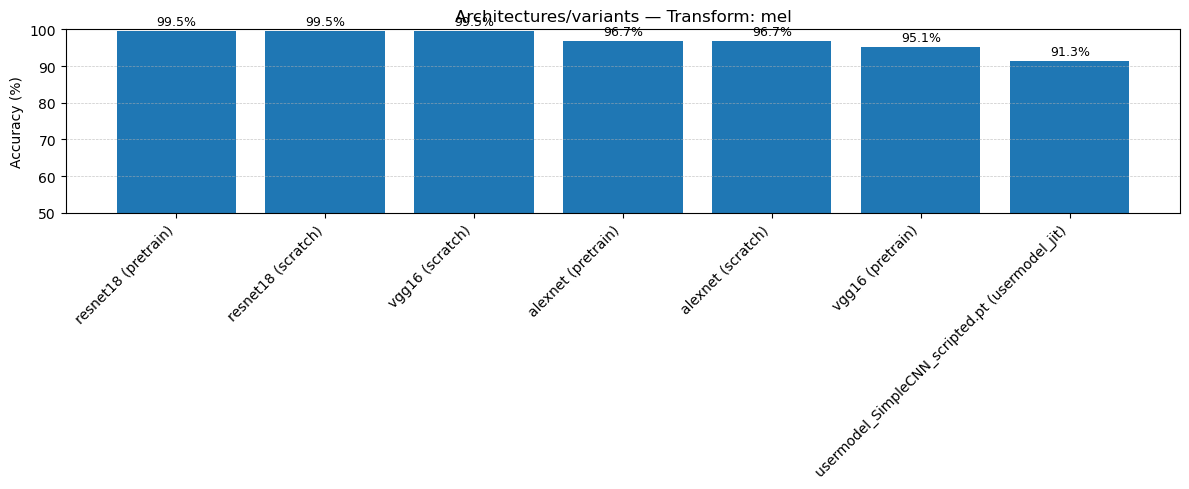

[metrics] Figure saved -> D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_with_metrics\reports\fig_arch_mel_acc.png


In [12]:
# Figuras (se guardan en 'reports/' al pasar out_name)
rep.plot_architectures_for_transform(df, transform="mel", metric="accuracy",
                                     y_min=50, y_max=100, out_name="fig_arch_mel_acc.png")


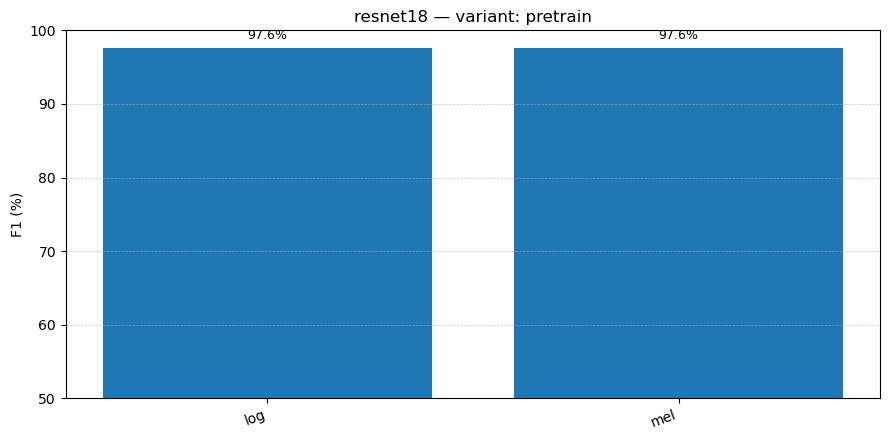

[metrics] Figure saved -> D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_with_metrics\reports\fig_resnet18_pretrain_f1.png


In [13]:
rep.plot_variants_for_model(df, model="resnet18", variant="pretrain", metric="f1",
                              y_min=50, y_max=100, out_name="fig_resnet18_pretrain_f1.png")


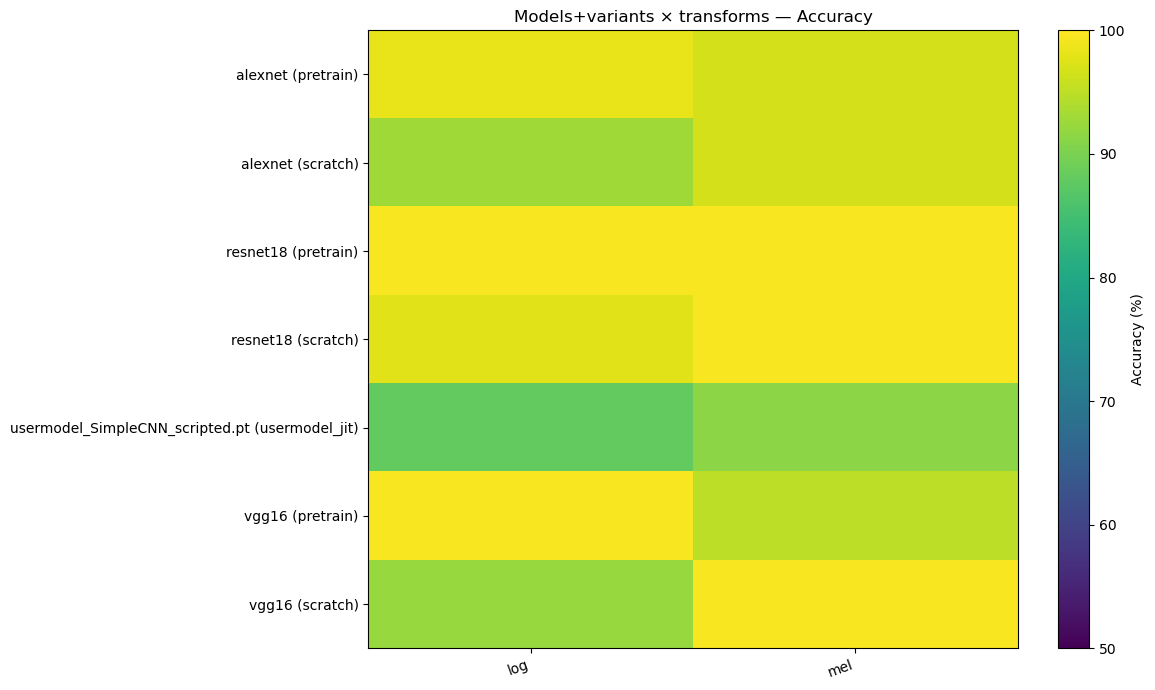

[metrics] Figure saved -> D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_with_metrics\reports\fig_heatmap_acc.png


In [14]:
rep.plot_heatmap_models_transforms(df, metric="accuracy", vmin=50, vmax=100,
                                   out_name="fig_heatmap_acc.png")
